# Importing our required libraries

In [1]:
# importing required liberaries
import requests
import numpy as np
import cv2
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
import itertools
from IPython.display import clear_output


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import copy

In [3]:
# this gives a track of the latest frame displayed by open cv
var_p1 = [] 
image_with_filter = [] 

# setting up our highper parameters for displaying facial key points if needed
color = (0, 0, 255) 
thickness = 2
radius = 2

# Loading  architechture and weights of our Trained model

We are loading the architecture of our pretrained model from .json file
Loading weights from the .hdf5 file 

In [4]:
with open('KeyPointDetector.json','r') as json_file:

    json_SavedModel = json_file.read()
model = tf.keras.models.model_from_json(json_SavedModel)
model.load_weights('weights.hdf5')

Getting the names of key points

In [6]:
facialpoints_df = pd.read_csv('training.csv')
columns = facialpoints_df.columns[:-1]
del facialpoints_df
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [8]:
len(columns)

30

Using Haarcascade classifier to detect the frountal face

In [9]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Filters

loading the filters from filters folder
I am using santa beard as filter but you can add more filters

In [10]:
filter_image = cv2.imread('filters/santa_filter.png',-1)
filter_image  = filter_image.astype(np.int16)
filter_image_copy = copy.copy(filter_image)

# K Means clustering

Since, we have the hardware restrictions.Therefore the model is trained on image shape of (96 X 96 X 1).
The key points predicted are also on the image of size (96 X 96 X 1).
In order to get keypoints on higher image dimensions we use the Kmeans clustering 
Furthur detailed visuals are given at in the 'detecting_facial_points.ipynb' notebook

In [11]:
    kmeans = KMeans(
                init="random",
                n_clusters=1,
                n_init=1,
                max_iter=1,
                random_state=42
                )

Here we will be calculating the key points on much higher image dimensions

In [12]:
def enlarged_point(df_predict_copy,frame_width,frame_hight):
        df_predict_copy = df_predict_copy.astype(np.int16)
        df_predict_copy = np.array(df_predict_copy)
        key_points = []
        for i in range(1,31,2):     
            b2_frame = np.zeros((96,96,1))
            
            b2_frame[df_predict_copy[0,i],df_predict_copy[0,i-1]] = 255
            x_y = []
            b2_frame = cv2.resize(b2_frame,(og_width,og_hight))
            hx ,hy = b2_frame.shape
            for i in range(hx):
                for j in range(hy):
                    if b2_frame[i,j] :

                        x_y.append([i,j])
            x_y = np.array(x_y)
            kmeans.fit(x_y[:,:2])
            
            key_points.append(kmeans.cluster_centers_)

        return key_points

These are the list of keypoints which we have on our enlarged image or the original image

In [ ]:
# 0 : left_eye_center
# 1 : right_eye_center
# 2 : left_eye_inner_corner
# 3 : left_eye_outer_corner
# 4 : right_eye_inner_corner
# 5 : right_eye_outer_corner
# 6 : left_eyebrow_inner_end
# 7 : left_eyebrow_outer_end
# 8 : right_eyebrow_inner_end
# 9 : right_eyebrow_outer_end
# 10 : nose_tip
# 11 : mouth_left_corner
# 12 : mouth_right_corner
# 13 : mouth_center_top_lip
# 14 : mouth_center_bottom_lip

Here we will be changing the pixel values of our frame in such a way that we we get the filter on right position with right size

In [13]:
def santa_filter(key_points,frame_width,frame_hight,x,y):
        key_points = np.array(key_points)
        
#       calculatin the size of the filter.
#       Here I have taken the width of filter as little larger than distance of outer eyebrow corners 

        size_width = (key_points[9,0] - key_points[7,0])*4/3
        size_hight = size_width
        
        
        size_width = size_width.astype(np.int16)
        size_hight = size_hight.astype(np.int16)
        
#       positioning the filter
#       I have placed the filter starting from below the nose, keeping nose in the center of filter width
        
        y_dist =  key_points[10,1] 
        x_dist =  key_points[10,0] - size_width/2 
        
        x_dist = x_dist.astype(np.int16)
        y_dist = y_dist.astype(np.int16)
        
        
#       getting the filter image 
        try:
           
            g = cv2.resize(filter_image_copy,(size_width,size_hight))

            g = tf.keras.preprocessing.image.array_to_img(g)
        
            arr_filter = img_to_array(g)

        
            x_dist = x_dist.astype(np.int16)
            y_dist = y_dist.astype(np.int16)

            
#           Here I have replaced the pixel values of the frame to that of filter image
            for i, j in itertools.product(range(arr_filter.shape[1]), range(arr_filter.shape[0])):
                if arr_filter[i,j,3] !=0:
                    for z in range(3):
                        try:
                            render[i+y_dist, j+x_dist,z] = arr_filter[i,j,z]
                        except:
                            continue


        except:
            clear_output(wait=True)
            print('error==> ignore if the filter works fine')
            
    

In [14]:
check_coordinates = []

In [15]:
# we use the ip webcam for using mobile camera for displaing on our pc 
while True:

    # getting the address for our mobile camera
    
    # here instead of 192.168.44.1:8080 you write your own ip given by ip webcam for your android
    image = requests.get("http://192.168.43.1:8080/shot.jpg") 
    
    # conveerting into numpy array
    video = np.array(bytearray(image.content),dtype = np.uint8)
    
    # decoding our numpy array
    render = cv2.imdecode(video,-1)
    
    #cv2.imshow('frame',render)
     
    
    
    # converting into gray scale from rgb
    gray = cv2.cvtColor(render, cv2.COLOR_BGR2GRAY)
    
    # detecting faces
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    # making a rectangle box on the detected faces
    for (x,y,w,h) in faces:
        var_p1 = render[ y:y+h ,x:x+w,1]
        render = cv2.rectangle(render,(x,y),(x+w,y+h),(255,0,0),2)
        
        og_width,og_hight = var_p1.shape
        
#       taking the image of the face and reizing it according to the input shape of our model

        image_sample = cv2.resize(var_p1,(96,96))
        img = array_to_img(image_sample.reshape((96,96,1)))
        arr = img_to_array(img)
        
        background_image = arr
        arr = arr/255
        arr = arr.reshape((1,96,96,1))
        
#       prdecting the key points on the image of the face
        df_predict = model.predict(arr)
    
#         print('model_predicted')
        df_enlarged_points = []
        df_sample = df_predict
#         key_points = np.zeros((15,2))

#       getting the key points on the original size of the image of the face 
        try: 
            key_points = enlarged_point(df_sample,og_width,og_hight)
            key_points = np.array(key_points)
            key_points = np.reshape(key_points,(15,2))
            key_points = key_points.astype(np.int16)
        except:
            continue
        
        

#       getting the coordinates of all key points on the frame displayed by open cv
        try:
            true_coordinates = []
            for i in range(15):
                center_coordinates = (x+key_points[i,1],y+key_points[i,0])
                
                true_coordinates.append(center_coordinates)
                
        except:
            continue
        
#       getting a sample coordinates of key points for furthur visualization and improvment
        check_coordinates = true_coordinates
         
#       applying the santa beard as a filter on the face
        try:
            santa_filter(true_coordinates ,og_width, og_hight,x,y)
        except:
            continue
            
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = render[y:y+h, x:x+w]
        
    # displaying the video frame with detected faces
    cv2.imshow('frame',render)
    
    # setting our terminating commands
    if (cv2.waitKey(1)==ord('q')):
        cv2.destroyAllWindows()
        break

error==> ignore if the filter works fine


# Grayscale visual of a applied filter

Here is a black and white representation of applied filter but it displays on rgb frame while running the notebook
I have plotted the Key points also for refrence

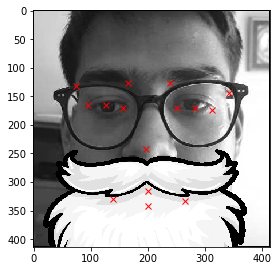

In [16]:
fig = plt.figure(figsize=(20,20))

for i in range(1):
    ax = fig.add_subplot(4,2,i+1)

    plt.imshow(var_p1,cmap='gray')

    for j in range(15):
        plt.plot(key_points[j,1], key_points[j , 0],'rx')